In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.table import Table
import numpy.ma as ma
from skimage.filters import gaussian
import sys
sys.path.insert(1,"/Users/nityaravi/Documents/Github/RotationCurves/spirals/")
from DRP_rotation_curve import extract_data


In [2]:
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['figure.dpi'] = 100

In [9]:
folder = '/Users/nityaravi/Documents/Research/RotationCurves/data/manga/output_files/DR17/CURRENT_MASTER_TABLE/'
fn = folder + 'H_alpha_HIvel_BB_extinction_H2_MxCG_R90_v3p5_Z_SFR_Portsmouthflux_Zglob_HIR90.fits'
MANGA_FOLDER = '/Users/nityaravi/Documents/Research/RotationCurves/data/manga/'
NSA_FILENAME = '/Users/nityaravi/Documents/Research/RotationCurves/data/nsa_v1_0_1.fits'
VEL_MAP_FOLDER = MANGA_FOLDER + 'DR17/'
IMAGE_DIR = MANGA_FOLDER + 'PAPER_PLOTS/'

In [10]:
t = Table.read(fn, format='fits')
t_dict = {}
for i in range(0, len(t)):
    gal_ID = t['plateifu'][i]
    t_dict[gal_ID] = i

In [11]:
def find_vel_bounds(mHa_vel, gal_ID):
    '''
    Locate the minimum and maximum velocities of the velocity distribution that
    is continuously linked to the most common velocity (normally around 0)
    found in the velocity map.


    PARAMETERS
    ==========

    mHa_vel : masked ndarray of shape (n,n)
        Masked H-alpha velocity map, in units of km/s

    gal_ID : string
        <MaNGA plate>-<MaNGA IFU>


    RETURNS
    =======

    min_vel, max_vel : float
        The minimum and maximum velocities of this continous distribution (in
        units of km/s).

    modified_mask : boolean ndarray of shape (n,n)
        Values of true correspond to masked locations (either already masked, or
        with velocities outside of the determined velocity range).
    '''

    bin_width = 10 # Bin the velocity in bins of 10 km/s

    if gal_ID in ['8150-12703', '8980-1902', '8261-6104','11958-3701']:
        bin_width = 5

    vel_extreme = ma.max(ma.abs(mHa_vel)) # Maximum velocity in the map

    vel_bin_counts, vel_bin_edges = np.histogram(mHa_vel.compressed(),
                                                 bins=np.arange(-vel_extreme,
                                                                vel_extreme + bin_width,
                                                                bin_width))

    ############################################################################
    # Find the bin with the most counts
    #---------------------------------------------------------------------------
    center_bin = np.argmax(vel_bin_counts)
    ############################################################################


    ############################################################################
    # Find the highest bin in which data is connected back to this central bin
    #---------------------------------------------------------------------------
    max_bin = center_bin + 1

    while max_bin < len(vel_bin_counts) and vel_bin_counts[max_bin] > 0:
        max_bin += 1

    max_vel = vel_bin_edges[max_bin]
    ############################################################################


    ############################################################################
    # Find the lowest bin in which data is connected back to the central bin
    #---------------------------------------------------------------------------
    if center_bin == 0:
        min_bin = 0
    else:
        min_bin = center_bin - 1

    while vel_bin_counts[min_bin] > 0 and min_bin > 0:
        min_bin -= 1

    min_vel = vel_bin_edges[min_bin]
    ############################################################################


    ############################################################################
    # Build the new mask, masking out all spaxels with velocities outside the
    # range (min_vel, max_vel).
    #---------------------------------------------------------------------------
    bad_vel = np.logical_or(mHa_vel < min_vel, mHa_vel > max_vel)

    new_mask = np.logical_or(mHa_vel.mask > 0, bad_vel)
    ############################################################################

    return new_mask, vel_bin_counts, vel_bin_edges, min_vel, max_vel

def find_sigma_bounds(mHa_sigma, gal_ID):
    '''
    Locate the maximum line width of Ha that is continuously linked to the
    smallest line width (normally around 0) found in the line width map.


    PARAMETERS
    ==========

    mHa_sigma : masked ndarray of shape (n,n)
        Masked H-alpha line width map, in units of km/s

    gal_ID : string
        <MaNGA plate>-<MaNGA IFU>


    RETURNS
    =======

    max_sigma : float
        The maximum line width of this continous distribution (in units of
        km/s).

    modified_mask : boolean ndarray of shape (n,n)
        Values of true correspond to masked locations (either already masked, or
        with line widths larger than the determined line width maximum).
    '''

    bin_width = 10 # Bin the line widths in bins of 10 km/s

    if gal_ID in ['8601-1902', '9037-12703', '8724-12701', '9088-12702',
                  '8551-12703', '8452-12703', '7960-12704', '8481-12705',
                  '10001-12705', '8319-12705', '9869-12705', '9045-1901',
                  '8446-1901', '8555-1901', '8551-1901', '8158-1901',
                  '8453-1901', '8244-1902', '9888-3701', '8335-3701',
                  '8261-3701', '8552-3702', '8725-3703', '8999-3704',
                  '9501-3704', '8257-6101', '8483-6101', '8244-6101',
                  '8131-6101', '8338-6103', '8985-6104', '8935-6104',
                  '8591-6104', '8944-6104', '8239-9101', '8154-9101',
                  '8320-9101', '8086-9102', '8081-9102', '9184-9102',
                  '7958-6101']:
        bin_width = 20
    elif gal_ID in ['8341-12704']:
        bin_width = 5

    sigma_extreme = ma.max(mHa_sigma) # Maximum line width in the map

    sigma_bin_counts, sigma_bin_edges = np.histogram(mHa_sigma.compressed(),
                                                     bins=np.arange(0,
                                                                    sigma_extreme + bin_width,
                                                                    bin_width))
    ############################################################################
    # Find the smallest-width bin with counts
    #---------------------------------------------------------------------------
    low_bin = 0

    while low_bin < len(sigma_bin_counts) and sigma_bin_counts[low_bin] == 0:
        low_bin += 1
    ############################################################################


    ############################################################################
    # Find the highest bin in which data is connected back to this lowest bin
    #---------------------------------------------------------------------------
    max_bin = low_bin + 1

    while max_bin < len(sigma_bin_counts) and sigma_bin_counts[max_bin] > 0:
        max_bin += 1

    max_sigma = sigma_bin_edges[max_bin]
    ############################################################################


    ############################################################################
    # Build the new mask, masking out all spaxels with line widths larger than
    # max_sigma.
    #---------------------------------------------------------------------------
    bad_sigma = mHa_sigma > max_sigma

    new_mask = np.logical_or(mHa_sigma.mask > 0, bad_sigma)
    ############################################################################

    return new_mask, sigma_bin_counts, sigma_bin_edges, max_sigma

In [12]:
gal_ID = '10001-12701'


i_t = t_dict[gal_ID]
phi_angle = t['nsa_elpetro_phi'][i_t]
vsys = t['v_sys'][i_t]

maps = extract_data(VEL_MAP_FOLDER,
                    gal_ID,
                    ['Ha_vel', 'Ha_flux', 'Ha_sigma', 'r_band'])

vel = maps['Ha_vel']
vel_mask = maps['Ha_vel_mask']
vel_ivar = maps['Ha_vel_ivar']

Ha_flux = maps['Ha_flux']
Ha_flux_mask = maps['Ha_flux_mask']
Ha_flux_ivar = maps['Ha_flux_ivar']

Ha_sigma_ivar = maps['Ha_sigma_ivar']


vel_mask = np.logical_or(vel_mask > 0, np.abs(Ha_flux*np.sqrt(Ha_flux_ivar)) < 5)

mvel = ma.array( vel, mask=vel_mask)
    

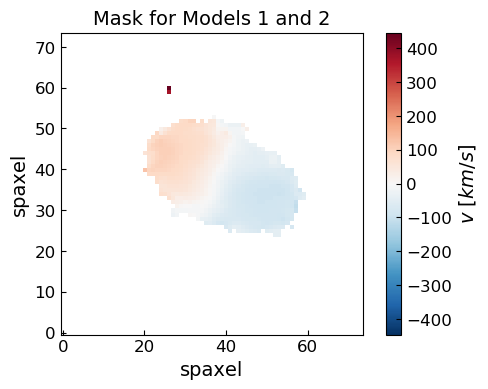

In [35]:
#plt.imshow(mvel, cmap='RdBu_r')
fig, ax = plt.subplots()

vmax = ma.max(mvel)
vmin = -vmax

vel_im = ax.imshow( mvel, 
                        cmap='RdBu_r', 
                        origin='lower', 
                        vmin=vmin, 
                        vmax=vmax)


cbar_ticks = [-400,-300,-200,-100,0,100,200,300,400]

#np.linspace( vmin, vmax, 11, dtype='int')
cbar = plt.colorbar(vel_im, ticks=cbar_ticks)
cbar.ax.tick_params( direction='in', labelsize=12)
cbar.set_label(r'$v\ [km/s]$', fontsize=14)
plt.xlabel('spaxel', fontsize=14)
plt.ylabel('spaxel', fontsize=14)
plt.tick_params(direction='in', labelsize=12)
plt.title('Mask for Models 1 and 2', fontsize=14)

#plt.gca().invert_yaxis()
plt.savefig(IMAGE_DIR + 'default_mask_v2.eps',bbox_inches = 'tight', pad_inches = 0)

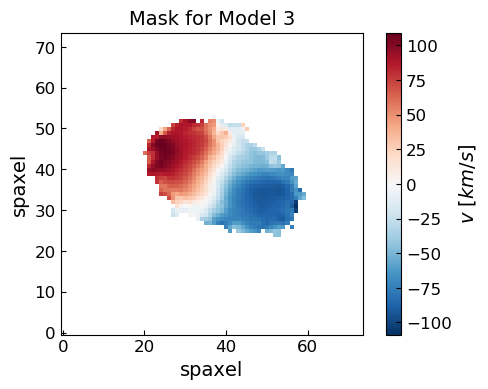

In [128]:
c_mask, c_vel_counts, c_vel_bins, min_vel, max_vel = find_vel_bounds(mvel, gal_ID)
c_mvel = ma.array(mvel, mask=mvel.mask + c_mask)
plt.imshow(c_mvel, cmap='RdBu_r')
cbar = plt.colorbar()
cbar.ax.tick_params( direction='in', labelsize=12)
cbar.set_label(r'$v\ [km/s]$', fontsize=14)
plt.xlabel('spaxel', fontsize=14)
plt.ylabel('spaxel', fontsize=14)
plt.tick_params(direction='in', labelsize=12)
plt.title('Mask for Model 3', fontsize=14)
plt.gca().invert_yaxis()
plt.savefig(IMAGE_DIR + 'continuous_mask.eps',bbox_inches = 'tight', pad_inches = 0)

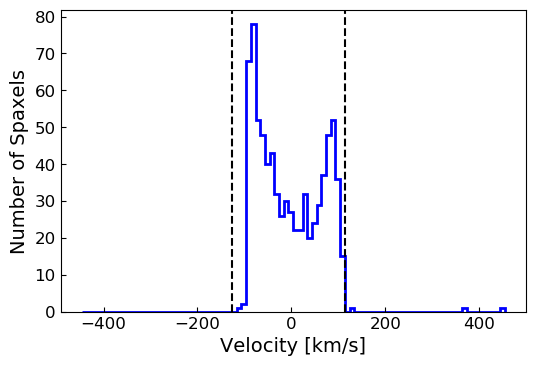

In [139]:
plt.hist(c_vel_bins[:-1], c_vel_bins, weights=c_vel_counts,histtype=u'step', color='b', linewidth=2)
plt.tick_params(labelsize=12, direction='in')
plt.axvline(min_vel, color='k', linestyle='--')
plt.axvline(max_vel, color='k', linestyle='--')
plt.xlabel('Velocity [km/s]', fontsize=14)
plt.ylabel('Number of Spaxels', fontsize=14)
plt.savefig(IMAGE_DIR + 'vel_hist.eps',bbox_inches = 'tight', pad_inches = 0)
# add dashed lines for empty bin and in caption say we remove outside the vertical lines

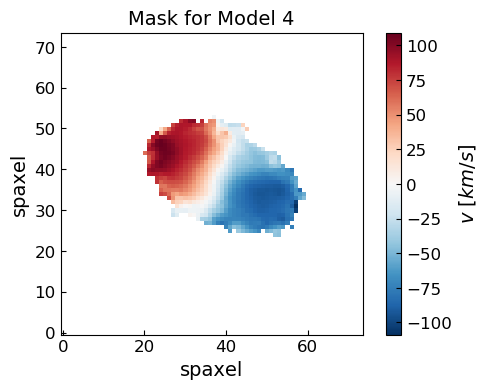

In [134]:
a_mask, a_vel_counts, a_vel_bins, max_sigma = find_sigma_bounds(mvel, gal_ID)
a_mvel = ma.array(mvel, mask=mvel.mask + a_mask)
plt.imshow(a_mvel, cmap='RdBu_r',)
cbar = plt.colorbar()
cbar.ax.tick_params( direction='in', labelsize=12)
cbar.set_label(r'$v\ [km/s]$', fontsize=14)
plt.xlabel('spaxel', fontsize=14)
plt.ylabel('spaxel', fontsize=14)
plt.tick_params(direction='in', labelsize=12)
plt.title('Mask for Model 4', fontsize=14)
plt.gca().invert_yaxis()
plt.savefig(IMAGE_DIR + 'no_agn_mask.eps',bbox_inches = 'tight', pad_inches = 0)

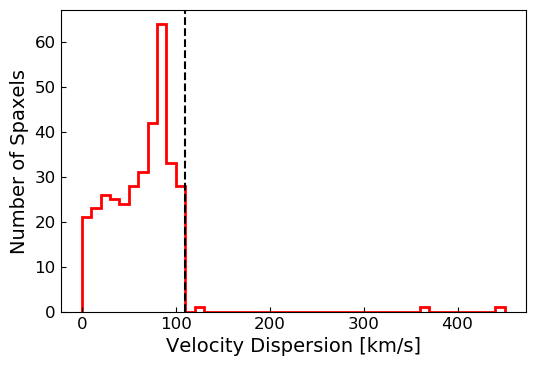

In [140]:
plt.hist(a_vel_bins[:-1], a_vel_bins, weights=a_vel_counts, histtype=u'step', color='r', linewidth=2)
plt.tick_params(labelsize=12, direction='in')
plt.axvline(max_sigma, linestyle='--', color='k')
plt.xlabel('Velocity Dispersion [km/s]', fontsize=14)
plt.ylabel('Number of Spaxels', fontsize=14)
plt.savefig(IMAGE_DIR + 'vel_disp_hist.eps',bbox_inches = 'tight', pad_inches = 0)
#add vertical line 